In [1]:
# import the required packages
import torch
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
import os
from numpy import random

In [2]:
#ls /data/all/train/images/

In [3]:
#download the rock paper scissors dataset
# !wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip

In [4]:
#!unzip rps

In [5]:
#ls rps

### Build the data loader
The dataloader should return the image and the mask

We will only load a fraction of the data first to ensure that the model works

In [6]:
# will keep the test set for hold out, we need to get the val set generated from train files so that we can shuffle well
train_images_path =  '/data/all/train/images'
file_list = os.listdir(train_images_path)
print(len(file_list))

208836


In [7]:
val_ratio = 0.2
SEED = 2021
random.seed(SEED)
#file_list = [i for i in range(len(patient_list))]
num_files = len(file_list)
idxs = np.arange(num_files)
random.shuffle(idxs)
train_image_files = np.array(file_list)[idxs][:int(num_files*(1-val_ratio))]
train_mask_files = [fn.replace('img','mask') for fn in train_image_files]

val_image_files = np.array(file_list)[idxs][int(num_files*(1-val_ratio)):]
val_mask_files = [fn.replace('img','mask') for fn in val_image_files]

In [8]:
# use only a subset of the images, to test the model first
num_tr_files = len(train_image_files)
num_val_files = len(val_image_files)
frac = 0.1 # use only 10% of samples
train_image_files = train_image_files[:int(num_tr_files*frac)]
train_mask_files = train_mask_files[:int(num_tr_files*frac)]
val_image_files = val_image_files[:int(num_val_files*frac)]
val_mask_files = val_mask_files[:int(num_val_files*frac)]

In [9]:
print("Training samples {} and val samples {}".format(len(train_image_files), len(val_image_files)))

Training samples 16706 and val samples 4176


In [10]:
[(img, msk) for img, msk in zip(train_image_files[:5], train_mask_files[:5])]

[('img_LIDC-IDRI-0450_114.npz', 'mask_LIDC-IDRI-0450_114.npz'),
 ('img_LIDC-IDRI-0886_27.npz', 'mask_LIDC-IDRI-0886_27.npz'),
 ('img_LIDC-IDRI-0486_64.npz', 'mask_LIDC-IDRI-0486_64.npz'),
 ('img_LIDC-IDRI-0791_92.npz', 'mask_LIDC-IDRI-0791_92.npz'),
 ('img_LIDC-IDRI-0407_88.npz', 'mask_LIDC-IDRI-0407_88.npz')]

#### The dataloader class

In [125]:
class nodule_data(Dataset):
    def __init__(self,image_paths,mask_paths):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        
        image = np.load('/data/all/train/images/' + self.image_paths[index])['arr_0'].astype('float32')
        mask  = np.load('/data/all/train/masks/' + self.mask_paths[index])['arr_0'].astype('float32')
        image -= np.mean(image)
        image /= np.std(image)

        return image[np.newaxis,:], mask[np.newaxis,:]

batch_size  = 1
num_workers = 1
nodule_data_train = nodule_data(train_image_files, train_mask_files)
nodule_data_val   = nodule_data(val_image_files, val_mask_files)

train_loader = DataLoader(nodule_data_train, batch_size = batch_size,
                             num_workers = num_workers)

val_loader   = DataLoader(nodule_data_val, batch_size = batch_size,
                             num_workers = num_workers)

In [126]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.10.0a0+3fd9dcf
Number of GPUs = 4


In [127]:
dataiter = iter(train_loader)
images,labels=dataiter.next()
print(images.dtype, ",", labels.dtype)

torch.float32 , torch.float32


In [128]:
batch_size = 128
n_classes = 3
embedding_dim = 100
latent_dim = 100

In [129]:
# train_transform = transforms.Compose([
#     transforms.Resize(128),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])
# train_dataset = datasets.ImageFolder(root='rps', transform=train_transform)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [130]:
# dataiter = iter(train_loader)
# images,labels=dataiter.next()
# images.dtype

In [131]:
images.shape

torch.Size([1, 1, 512, 512])

In [132]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
     
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))
        
    
        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))
           

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                      nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

In [133]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
    
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*128*128))
             
        self.model = nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

In [134]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.10.0a0+3fd9dcf
Number of GPUs = 4


In [135]:
device = torch.device("cuda")

In [136]:
# custom weights initialization called on gen and disc model
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [137]:
adversarial_loss = nn.BCELoss()
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    #print(gen_loss)
    return gen_loss

In [138]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [139]:
generator = Generator().to(device)
generator.apply(weights_init)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=49152, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)


In [140]:
learning_rate = 0.0002 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [141]:
generator = torch.nn.parallel.DataParallel(generator, device_ids=[0,1,2,3]).cuda()
discriminator = torch.nn.parallel.DataParallel(discriminator, device_ids=[0,1,2,3]).cuda()

In [143]:
torch.cuda.empty_cache()

In [145]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 8            |        cudaMalloc retries: 8         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  683304 KB |  785704 KB |    1813 MB |    1146 MB |\n|       from large pool |  675328 KB |  777728 KB |    1798 MB |    1138 MB |\n|       from small pool |    7976 KB |    9000 KB |      15 MB |       7 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |  683304 KB |  785704 KB |    1813 MB |    1146 MB |\n|       from large pool |  675328 KB |  777728 KB |

In [150]:
num_epochs = 20
train_loss = []
val_loss   = []
for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], []
    running_d_loss = 0.0
    running_g_loss = 0.0
    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()

      
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
      
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()
    
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
        
       
        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)

    
        # train with fake
        #D_fake_loss.backward()
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
        
      
        D_total_loss.backward()
        D_optimizer.step()
        running_d_loss += D_total_loss.item()
        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()
        running_g_loss += G_loss.item()
    running_d_loss /= index+1
    running_g_loss /= index+1
    print(f"Epoch {epoch} trained with discriminator loss: {running_d_loss} and generator loss: {running_g_loss}")

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1056, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_901/3205519459.py", line 28, in forward
    label_output = self.label_condition_disc(label)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1056, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py", line 139, in forward
    input = module(input)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1056, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/linear.py", line 99, in forward
    return F.linear(input, self.weight, self.bias)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py", line 1850, in linear
    return torch._C._nn.linear(input, weight, bias)
RuntimeError: CUDA out of memory. Tried to allocate 48.00 GiB (GPU 0; 14.76 GiB total capacity; 776.29 MiB already allocated; 13.18 GiB free; 892.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [ ]:
real_images.shape

In [147]:
noise_vector.shape

NameError: name 'noise_vector' is not defined

In [107]:
labels

tensor([0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 1, 2, 1, 2, 0,
        2, 0, 2, 1, 1, 0, 2, 0, 0, 1, 2, 2, 1, 2, 2, 0, 1, 0, 0, 2, 1, 1, 1, 1,
        0, 2, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0,
        2, 0, 0, 0, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 0, 0,
        0, 2, 0, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 2,
        1, 0, 0, 2, 2, 2, 0, 0])

In [100]:
noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
noise_vector = noise_vector.to(device)


generated_image = generator((noise_vector, labels))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper__index_select)

In [91]:
gen_img = generated_image.cpu().detach().numpy()

In [101]:
gen_img.shape

(88, 3, 128, 128)

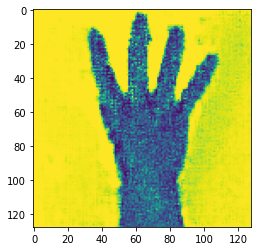

In [108]:
plt.imshow(gen_img[0,1,:,:])